In [1]:
from sqlalchemy import create_engine
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
DB_PARAMS = {
    "dbname": os.getenv("POSTGRES_DB"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"), 
    "host": "postgres",
    "port":  5432
}

In [4]:
try:
    db_url = f"postgresql+psycopg2://{DB_PARAMS['user']}:{DB_PARAMS['password']}@{DB_PARAMS['host']}/{DB_PARAMS['dbname']}"
    engine = create_engine(db_url)

    query = """
        WITH customer_times AS (
            SELECT
                user_id,
                MIN(event_time) AS first_purchase_time,
                MAX(event_time) AS last_purchase_time
            FROM customers
            GROUP BY user_id
        ),
        classification AS (
            SELECT
                user_id,
                first_purchase_time,
                last_purchase_time,
                CASE
                    WHEN first_purchase_time > (SELECT MAX(last_purchase_time) FROM customer_times) - INTERVAL '30 days' THEN 'New customer'
                    WHEN last_purchase_time <= (SELECT MAX(last_purchase_time) FROM customer_times) - INTERVAL '90 days' THEN 'Inactive customer'
                    WHEN last_purchase_time > (SELECT MAX(last_purchase_time) FROM customer_times) - INTERVAL '30 days' THEN 'Platino'
                    WHEN last_purchase_time > (SELECT MAX(last_purchase_time) FROM customer_times) - INTERVAL '60 days' THEN 'Oro'
                    WHEN last_purchase_time > (SELECT MAX(last_purchase_time) FROM customer_times) - INTERVAL '90 days' THEN 'Plata'
                    ELSE 'Bronce'
                END AS status
            FROM customer_times
        ),
        customer_status_counts AS (
            SELECT 
                CASE
                    WHEN status IN ('Platino', 'Oro', 'Plata') THEN 'Loyal customer'
                    ELSE status
                END AS status,
                COUNT(*) AS total
            FROM classification
            GROUP BY status
        )
        SELECT * FROM customer_status_counts;
    """
    df = pd.read_sql(query, engine)

except Exception as e:
    print(f"❌ An error occurred: {e}")

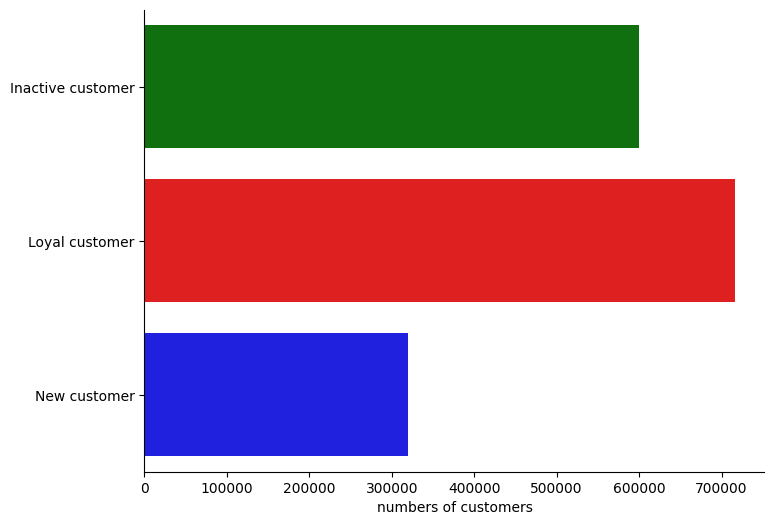

In [5]:
df_grouped = df.groupby('status', as_index=False).sum()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='total', y='status', data=df_grouped, hue='status', dodge=False, palette=['green', 'red', 'blue'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('numbers of customers')
ax.set_ylabel('')
plt.show()

In [ ]:
data_for_clustering = np.array(df[['total']].values)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

cluster_averages = []
for i in range(num_clusters):
    cluster_points = np.array([df['total'].iloc[j] for j in range(len(df)) if cluster_labels[j] == i])
    cluster_averages.append(np.mean(cluster_points))

sorted_indices = np.argsort(cluster_averages)

plt.figure(figsize=(10, 6))
group_names = {
    0: "gold",
    1: "inactive",
    2: "new customer",
    3: "silver",
    4: "platinum"
}

for i, idx in enumerate(sorted_indices):
    cluster_points = np.array([df['total'].iloc[j] for j in range(len(df)) if cluster_labels[j] == idx])
    color = plt.cm.viridis(i / num_clusters)
    plt.barh(i, np.mean(cluster_points), color=color, alpha=0.7)
    plt.text(np.mean(cluster_points) + 0.8, i, f'{group_names[idx]}', ha='left', va='center', fontsize=10, color='black', weight='bold')

plt.ylabel("")
plt.xlabel("Number of Customers (Average)")
plt.title("Distribution of Customers by Clusters")
plt.yticks(range(num_clusters), [f'Cluster {i+1}' for i in range(num_clusters)])
plt.grid(True)
plt.show()